In [1]:
# %matplotlib inline
import os 
import argparse
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #change to chosen GPU
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.optimizers import Adam, SGD, RMSprop
from keras.datasets import mnist, cifar10
from keras.utils import np_utils






Using TensorFlow backend.


In [2]:
import sys
import os
import numpy as np
import keras.backend as K
from keras.models import Model
from keras.layers import Input,merge
from keras.layers.merge import _Merge
from keras import initializers
from keras.initializers import RandomNormal
from keras.utils import vis_utils
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.activations import linear
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Activation, Reshape, Lambda, Dropout
from keras.layers.convolutional import Conv2D, Convolution2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.regularizers import *
from keras.applications.vgg16 import VGG16
from keras.constraints import unitnorm
from functools import partial
import tensorflow as tf
from normalization import *
import resnet50


In [3]:
def generator_google_mnistM(noise_dim, img_source_dim,img_dest_dim,deterministic,pureGAN,wd,suffix=None):
    """DCGAN generator based on Upsampling and Conv2D
    Args:
        noise_dim: Dimension of the noise input
        img_dim: dimension of the image output
        bn_mode: keras batchnorm mode
        model_name: model name (default: {"generator_upsampling"})
        dset: dataset (default: {"mnist"})
    Returns:
        keras model
    """
    s = img_source_dim[1]
#    shp = np.expand_dims(img_dim[1:],1) # to make shp= (None, 1, 28, 28)  but is not working
    start_dim = int(s / 4)
    input_channels = img_source_dim[-1]
    output_channels = img_dest_dim[-1]
    reshape_shape = (s, s, input_channels)
    shp=reshape_shape 
    gen_noise_input = Input(shape=noise_dim, name="generator_input")
    gen_image_input = Input(shape=shp, name="generator_image_input")

    # Noise input and reshaping
    x = Dense(5*s*s, input_dim=noise_dim,W_regularizer=l2(wd))(gen_noise_input)
    x = Reshape((s,s,5))(x)
    x = Activation("relu")(x)

    if deterministic: #here I link or not link the noise vector to the whole network
        g = gen_image_input
    elif pureGAN:
        g = x 
    else:
        g = merge([gen_image_input, x], mode='concat',concat_axis=3) # because of concat_axis=1, will it work on tensorflow NHWC too? 

    x1 = Conv2D(64, (3, 3), border_mode='same', kernel_initializer="he_normal",W_regularizer=l2(wd))(g) #convolved by 3x3 filter to get 64x55x35
    x1 = Activation('relu')(x1)

    for i in range(4):
        x = Conv2D(64, (3, 3), border_mode='same', kernel_initializer="he_normal",W_regularizer=l2(wd))(x1)
        x=BatchNormGAN(axis=1)(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), border_mode='same',  kernel_initializer="he_normal",W_regularizer=l2(wd))(x)
        x=BatchNormGAN(axis=1)(x)
        x1 = merge([x, x1], mode='sum')
        x1 = Activation('relu')(x1)

    # Last Conv to get the output image
    x1 = Conv2D(output_channels, (1, 1),name="gen_conv2d_final", border_mode='same', kernel_initializer="he_normal",W_regularizer=l2(wd))(x1)
    x1 = Activation('tanh')(x1)
    if suffix is None:
        generator_model = Model(input=[gen_noise_input,gen_image_input], output=[x1], name="generator_google1")
    else:
        generator_model = Model(input=[gen_noise_input,gen_image_input], output=[x1], name="generator_google2")
    visualize_model(generator_model)
    return generator_model


In [4]:
def discriminator_google_mnistM(img_dim,wd):

    disc_input = Input(shape=img_dim, name="discriminator_input")
    x = Conv2D(64, (3, 3), strides=(1, 1), name="conv1",border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input) 
    x=BatchNormGAN(axis=1)(x)
    x = Dropout(0.1)(x)
    x = LeakyReLU(0.2)(x)
    x = GaussianNoise( sigma=0.2 )(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), name="conv2",border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x) 
    x = Dropout(0.2)(x)
#    x = LeakyReLU(0.2)(x)
    x = GaussianNoise( sigma=0.2 )(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), name="conv3",border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x) 
    x=BatchNormGAN(axis=1)(x)
    x = Dropout(0.2)(x)
    x = LeakyReLU(0.2)(x)
    x = GaussianNoise( sigma=0.2 )(x)
    x = Conv2D(512, (3, 3), strides=(2, 2), name="conv4",border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x) 
    x = Dropout(0.2)(x)
 #   x = LeakyReLU(0.2)(x)
    x = GaussianNoise( sigma=0.2 )(x)
    x = Flatten()(x)
    x = Dense(1, init=RandomNormal(stddev=0.02),activation='sigmoid', name='fc',W_regularizer=l2(wd))(x)
    discriminator_model = Model(input=[disc_input], output=x, name="discriminator_google")
    visualize_model(discriminator_model)
    return discriminator_model

In [5]:
def discriminator_sem2(img_dim,wd,n_classes,disc_type):
    min_s = img_dim[1]
    disc_input = Input(shape=img_dim, name="discriminator_input")
#     y = Input(shape=(n_classes,), name = "labels")
    # Get the list of number of conv filters
    # (first layer starts with 64), filters are subsequently doubled
    nb_conv =int(np.floor(np.log(min_s // 4) / np.log(2)))
    list_f = [64 * min(8, (2 ** i)) for i in range(nb_conv)]

    x = Conv2D(list_f[0], (3, 3), strides=(2, 2), name="disc_conv2d_1",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
    x=BatchNormalization(axis=1)(x)
    x = LeakyReLU(0.2)(x)
    for i, f in enumerate(list_f[1:]):
        name = "disc_conv2d_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name,
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
        x=BatchNormalization(axis=1)(x)
        x = LeakyReLU(0.2)(x)
    aux = x
    x = Conv2D(1, (3, 3), strides=(1, 1), name="finale_conv",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
    aux = Flatten()(aux)
    aux = Dense(n_classes, activation='softmax', name='auxiliary',W_regularizer=l2(wd))(aux)
    
    x = GlobalAveragePooling2D()(x)
    
    #x --> Loss ,aux --> probability
    discriminator_model = Model(input=[disc_input], output=[x,aux], name="discriminator")

    visualize_model(discriminator_model)
   
    return discriminator_model


In [6]:
def discriminator_sem(img_dim,wd,n_classes,disc_type):
    min_s = img_dim[1]
    disc_input = Input(shape=img_dim, name="discriminator_input")

    # Get the list of number of conv filters
    # (first layer starts with 64), filters are subsequently doubled
    nb_conv =int(np.floor(np.log(min_s // 4) / np.log(2)))
    list_f = [64 * min(8, (2 ** i)) for i in range(nb_conv)]

    x = Conv2D(list_f[0], (3, 3), strides=(2, 2), name="disc_conv2d_1",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
    x=BatchNormalization(axis=1)(x)
    x = LeakyReLU(0.2)(x)
    for i, f in enumerate(list_f[1:]):
        name = "disc_conv2d_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name,
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
        x=BatchNormalization(axis=1)(x)
        x = LeakyReLU(0.2)(x)
    aux = x
    x = Conv2D(1, (3, 3), strides=(1, 1), name="finale_conv",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
    aux = Flatten()(aux)
    aux = Dense(n_classes, activation='softmax', name='auxiliary',W_regularizer=l2(wd))(aux)
    x = GlobalAveragePooling2D()(x)
    discriminator_model_domain = Model(input=[disc_input], output=[x], name="discriminator_domain")
    discriminator_model_class = Model(input=[disc_input], output=[aux], name="discriminator_class")

    visualize_model(discriminator_model_domain)
    visualize_model(discriminator_model_class)
   
    return discriminator_model_domain

In [7]:
def discriminator_sem3(img_dim,wd,n_classes,disc_type):
    min_s = img_dim[1]
    disc_input = Input(shape=img_dim, name="discriminator_input")

    # Get the list of number of conv filters
    # (first layer starts with 64), filters are subsequently doubled
    nb_conv =int(np.floor(np.log(min_s // 4) / np.log(2)))
    list_f = [64 * min(8, (2 ** i)) for i in range(nb_conv)]

    x = Conv2D(list_f[0], (3, 3), strides=(2, 2), name="disc_conv2d_1",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
    x=BatchNormalization(axis=1)(x)
    x = LeakyReLU(0.2)(x)
    for i, f in enumerate(list_f[1:]):
        name = "disc_conv2d_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name,
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
        x=BatchNormalization(axis=1)(x)
        x = LeakyReLU(0.2)(x)
    aux = x
    x = Conv2D(1, (3, 3), strides=(1, 1), name="finale_conv",
                      border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
    aux = Flatten()(aux)
    aux = Dense(n_classes, activation='softmax', name='auxiliary',W_regularizer=l2(wd))(aux)
    x = GlobalAveragePooling2D()(x)
    discriminator_model_domain = Model(input=[disc_input], output=[x], name="discriminator_domain")
    discriminator_model_class = Model(input=[disc_input], output=[aux], name="discriminator_class")

    visualize_model(discriminator_model_domain)
    visualize_model(discriminator_model_class)
   
    return discriminator_model_class

In [5]:
def get_optimizer(opt, lr):

    if opt == "SGD":
        return SGD(lr=lr)
    elif opt == "RMSprop":
        return RMSprop(lr=lr)
    elif opt == "Adam":
        return Adam(lr=lr, beta_1=0.5)
    elif opt == "AdamWithWeightnorm":
        return AdamWithWeightnorm(lr=lr, beta_1=0.5)
    elif opt == "SGDWithWeightnorm":
        return SGDWithWeightnorm(lr=lr)


In [6]:
def build_opt(opt_D, opt_G, lr_D, lr_G):
    _opt_D = get_optimizer(opt_D, lr_D)
    _opt_G = get_optimizer(opt_G, lr_G)
    _opt_C = get_optimizer('SGD', 0.01)
    _opt_Z = get_optimizer('Adam', lr_G)
    return _opt_D, _opt_G, _opt_C, _opt_Z


In [7]:
def visualize_model(model):
    model.summary()
    vis_utils.plot_model(model,
                        to_file='./figures/%s.png' % model.name,
                        show_shapes=True,
                        show_layer_names=True)


In [8]:
opt_D1, opt_G1, opt_C1, opt_Z1 = build_opt('Adam','Adam', 0.0001, 0.0001)


In [23]:
noise_dim = (100,)
img_source_dim = (28,28,1)
img_dest_dim = (28,28,1)
deterministic = False
pureGAN = False
wd = 1e-05
suffix = None
n_classes = 10
disc_type = 'nclass_disc'


In [24]:
generator_model = generator_google_mnistM(noise_dim, img_source_dim, img_dest_dim, deterministic, 
                                                 pureGAN, wd,suffix)
discriminator_model = discriminator_google_mnistM(img_dest_dim, wd)
# discriminator_model2 = discriminator_sem2(img_dest_dim, wd,n_classes,disc_type)
# discriminator_model3 = discriminator_sem3(img_dest_dim, wd,n_classes,disc_type)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3920, input_dim=(100,), kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 A

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_input (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 3920)         395920      generator_input[0][0]            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 28, 28, 5)    0           dense_3[0][0]                    
__________________________________________________________________________________________________
generator_image_input (InputLay (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), name="conv1", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `GaussianNoise` call to the Keras 2 API: `GaussianNoise(stddev=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2), name="conv2", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `GaussianNoise` call to the Keras 2 API: `GaussianNoise(stddev=0.2)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserW

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 64)        640       
_________________________________________________________________
batch_norm_gan_27 (BatchNorm (None, 28, 28, 64)        112       
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 28, 28, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
__________

In [25]:
generator_model.compile(loss=['mse'], optimizer=opt_G1)
discriminator_model.compile(loss=['mse'], optimizer=opt_D1)
# discriminator_model2.compile(loss=['mse','categorical_crossentropy'], optimizer=opt_D1)
# discriminator_model3.compile(loss=['categorical_crossentropy'], optimizer=opt_D1)

# disc2.compile(loss=['categorical_crossentropy'], optimizer=opt_D1)

In [26]:
def gen_batch(X, Y, batch_size):
    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx], Y[idx], idx

In [27]:
def get_batch(A_data, A_labels, B_data, B_labels, batch_size):
    A_data_batch, A_labels_batch, _ = next(gen_batch(A_data, A_labels, batch_size))
    B_data_batch, B_labels_batch, _ = next(gen_batch(B_data, B_labels, batch_size))
    return A_data_batch, A_labels_batch, B_data_batch, B_labels_batch


In [28]:
def sample_noise(noise_scale, batch_size, noise_dim):
    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))

In [29]:
def normalization(X, image_dim_ordering):

    X = X / 255.
    if image_dim_ordering == "tf":
        X = (X - 0.5) / 0.5
    else:
        X = (X - 0.5) / 0.5
    return X


In [30]:
def load_mnist(image_dim_ordering):

    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    if image_dim_ordering == 'th':
        X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
        X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    else:
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
        X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train = normalization(X_train, image_dim_ordering)
    X_test = normalization(X_test, image_dim_ordering)

    nb_classes = len(np.unique(np.hstack((y_train, y_test))))

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    return X_train, Y_train, X_test, Y_test, nb_classes


In [31]:
def load_usps(image_dim_ordering):
    #Loading mnist labels, they should be the same of mnistM
    X_train=np.load("./data/USPS/usps_X_train28.npy")
    y_train=np.load("./data/USPS/usps_y_train.npy")
    X_test=np.load("./data/USPS/usps_X_test28.npy")
    y_test=np.load("./data/USPS/usps_y_test.npy")
    
#     path = './data/USPS/usps.h5'
#     with h5py.File(path, 'r') as hf:
#         train = hf.get('train')
#         X_train = train.get('data')[:]
#         y_train = train.get('target')[:]
#         test = hf.get('test')
#         X_test = test.get('data')[:]
#         y_test = test.get('target')[:]
    
#     X_train = X_train.reshape(X_train.shape[0],16,16)
#     X_test = X_test.reshape(X_test.shape[0],16,16)
    
#     train = []
#     for img in X_train:
#         resized_img = cv2.resize(img, (28, 28))
#         train.append(resized_img)
#     X_train = np.asarray(train)
    
#     del train[:]
#     for img in X_test:
#         resized_img = cv2.resize(img, (28, 28))
#         train.append(resized_img)
#     X_test = np.asarray(train)
    
    if image_dim_ordering == 'th':
        X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
        X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
        
    else:
        X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
        X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
   
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train = normalization(X_train, image_dim_ordering)
    X_test = normalization(X_test, image_dim_ordering)

   
    
    nb_classes = len(np.unique(np.hstack((y_train, y_test))))

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    return X_train, Y_train, X_test, Y_test, nb_classes


In [22]:
def load_mnistM(image_dim_ordering):

       #Loading mnist labels, they should be the same of mnistM
#    (_, y_train), (_, y_test) = mnist.load_data()
    X_train=np.load("./data/mnist-M_X_train.npy")
    X_test=np.load("./data/mnist-M_X_test.npy") 
    
    y_train=np.load("./data/mnist-M_X_train_labels.npy")
    y_test=np.load("./data/mnist-M_X_test_labels.npy") 
   

   
#    f = open('./data/mnistm_data.pkl', 'rb')
#    mnistm = pkl.load(f)
#    X_train = mnistm['train']
#    X_test = mnistm['test']
    
#    X_train = X_train.reshape(X_train.shape[0], 3, 28, 28)
#    X_test = X_test.reshape(X_test.shape[0], 3, 28, 28)
    if image_dim_ordering == 'th':
        X_train = X_train.reshape(X_train.shape[0], 3, 28, 28)
        X_test = X_test.reshape(X_test.shape[0], 3, 28, 28)
    else:
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 3)
        X_test = X_test.reshape(X_test.shape[0], 28, 28, 3)
#    X_train = X_train.astype('float32')
#    X_test = X_test.astype('float32')

    X_train = normalization(X_train, image_dim_ordering)
    X_test = normalization(X_test, image_dim_ordering)

    nb_classes = len(np.unique(np.hstack((y_train, y_test))))

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    return X_train, Y_train, X_test, Y_test,nb_classes

In [32]:
A_data, A_label, A_test_data, A_test_label, nb_class = load_mnist('tf')
B_data, B_label, B_test_data, B_test_label, nb_class = load_usps('tf')

In [33]:
A_data_batch, A_labels_batch, B_data_batch, B_labels_batch = get_batch(A_data, A_label, B_data, B_label, 32)
X_source_batch = A_data_batch
Y_source_batch = A_labels_batch
X_dest_batch = B_data_batch
Y_dest_batch = B_labels_batch


In [37]:

X_noise = sample_noise(0.5, 32, noise_dim)
gen_output = generator_model.predict([X_noise,X_source_batch])  #Generated labeled data

current_labels_real = np.ones(32) 
current_labels_gen = np.zeros((32,))

disc_loss_real = discriminator_model.train_on_batch(X_dest_batch, current_labels_real)

disc_loss_gen = discriminator_model.train_on_batch(gen_output,current_labels_gen)
# disc2_loss = discriminator2.train_on_batch(gen_output,Y_source_batch * 1.0)


In [ ]:
x_dest_batch = GAN.generator_model.predict([X_noise,A_data_batch])
train_data = np.concatenate((x_dest_batch[:16],B_data_batch[:16]),axis=0)
train_labels = np.concatenate((A_labels_batch[:16],p[:16]),axis=0)
class_loss2 = GAN.classificator_model.train_on_batch(train_data, train_labels)

class_loss3 = GAN.classificator_model2.train_on_batch(x_dest_batch, A_labels_batch)

In [ ]:
disc2.predict_on_batch(X_dest_batch)

In [ ]:
disc_loss_real2

In [ ]:
disc_loss_real2[0]

In [ ]:
disc_loss_unl

In [ ]:
X, Y = discriminator_model.predict(X_dest_batch)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
gen_output = generator_model.predict([X_noise,X_source_batch])

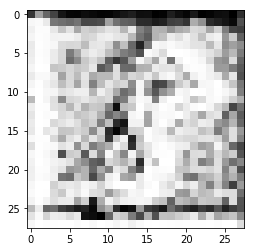

In [43]:
X = gen_output[1]
plt.imshow(X[:,:,0], cmap = 'gray')

In [ ]:
np.argmax(Y,axis=1)

In [ ]:
Y_source_batch

In [ ]:
np.ones((32,10))

In [ ]:
p2 = discriminator_model.predict(Xsource_dataset_mapped, batch_size=1000, verbose=1)


In [ ]:
score2 = np.sum(np.argmax(true_labels,axis=1) == np.argmax(p2, axis=1)) / float(true_labels.shape[0]) 